# Plot 

In [1]:
# Plot history
import pandas as pd
from matplotlib import pyplot as plt


def plot_ios(paths, labels):
    for path, label in zip(paths, labels):
        df = pd.read_csv(path)
        plt.plot(df.index, df.iou, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.title("Train IoU")
    plt.legend()
    plt.grid()
    plt.show()


def plot_loss(paths, labels):
    for path, label in zip(paths, labels):
        df = pd.read_csv(path)
        plt.plot(df.index, df.loss, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train Loss")
    plt.ylim((0, 0.05))
    plt.legend()
    plt.grid()
    plt.show()


plot_ios(("histories\history_pspnet_r18_400.csv", 
          "histories\history_model_deeplab_r18_500.csv",
          "histories\history_model_pspnet_mobilevit__500.csv"),
          ("pspnet (resnet18)", "deeplabv3+ (resnet18)", "pspnet (mobilevit)"))

plot_loss(("histories\history_pspnet_r18_400.csv", 
          "histories\history_model_deeplab_r18_500.csv",
          "histories\history_model_pspnet_mobilevit__500.csv"),
          ("pspnet (resnet18)", "deeplabv3+ (resnet18)", "pspnet (mobilevit)"))

FileNotFoundError: [Errno 2] No such file or directory: 'histories\\history_pspnet_r18_400.csv'

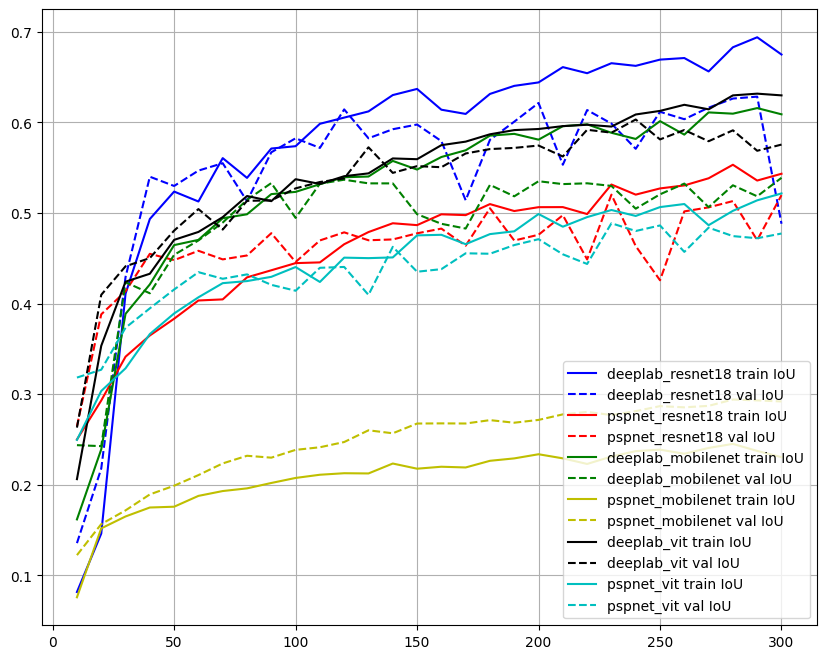

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import os


names = ["deeplab_resnet18", "pspnet_resnet18", "deeplab_mobilenet", "pspnet_mobilenet", "deeplab_vit", "pspnet_vit"]
colors = ["b", "r", "g", "y", "k", "c"]
ending = "__300.csv"

plt.figure(figsize=(10, 8))
for name, c in zip(names, colors):
    df = pd.read_csv(os.path.join("histories/for_visualisation", f"{name}{ending}"))
    plt.plot(range(10, 301, 10), df["iou"].iloc[1:], f"{c}-", label=f"{name} train IoU")
    plt.plot(range(10, 301, 10), df["val_iou"].iloc[1:], f"{c}--", label=f"{name} val IoU")

plt.grid()
plt.legend()
plt.show()

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import os


names = ["deeplab_resnet18", "pspnet_resnet18", "pspnet_mobilenet"]
ending = "__300.csv"

for name in names:
    df = pd.read_csv(os.path.join("histories/for_visualisation", f"{name}{ending}"))
    plt.plot(range(10, 301, 10), df["iou"].iloc[1:], "b-", label="")

plt.grid()
plt.legend()
plt.show()
print("Conclusion: need smaller lr")

: 

# Param count

In [4]:
import model_loader


model = model_loader.SegmentationModel("deeplabv3plus", "tu-mobilevitv2_050", 3, True)
print(f"deeplabv3plus mobilevitv2_050: {sum([p.numel() for p in model.parameters()]) / 1e6}")
model = model_loader.SegmentationModel("deeplabv3plus", "tu-mobilevitv2_100", 3, True)
print(f"deeplabv3plus mobilevitv2_100: {sum([p.numel() for p in model.parameters()]) / 1e6}")
model = model_loader.SegmentationModel("pspnet", "tu-mobilevitv2_100", 3, True)
print(f"pspnet mobilevitv2_100: {sum([p.numel() for p in model.parameters()]) / 1e6}")
model = model_loader.SegmentationModel("manet", "tu-mobilevitv2_100", 3, True)
print(f"manet mobilevitv2_100: {sum([p.numel() for p in model.parameters()]) / 1e6}")
model = model_loader.SegmentationModel("pan", "tu-mobilevitv2_100", 3, True)
print(f"pan mobilevitv2_100: {sum([p.numel() for p in model.parameters()]) / 1e6}")

print()
model = model_loader.SegmentationModel("deeplabv3plus", "timm-mobilenetv3_small_100", 3, True)
print(f"deeplabv3plus mobilenetv3_small_100: {sum([p.numel() for p in model.parameters()]) / 1e6}")
model = model_loader.SegmentationModel("pspnet", "timm-mobilenetv3_small_100", 3, True)
print(f"pspnet mobilenetv3_small_100: {sum([p.numel() for p in model.parameters()]) / 1e6}")

print()
model = model_loader.SegmentationModel("deeplabv3plus", "resnet18", 3, True)
print(f"deeplabv3plus resnet18: {sum([p.numel() for p in model.parameters()]) / 1e6}")
model = model_loader.SegmentationModel("pspnet", "resnet18", 3, True)
print(f"pspnet resnet18: {sum([p.numel() for p in model.parameters()]) / 1e6}")
model = model_loader.SegmentationModel("manet", "resnet18", 3, True)
print(f"manet resnet18: {sum([p.numel() for p in model.parameters()]) / 1e6}")
model = model_loader.SegmentationModel("pan", "resnet18", 3, True)
print(f"pan resnet18: {sum([p.numel() for p in model.parameters()]) / 1e6}")

deeplabv3plus mobilevitv2_050: 1.932269
deeplabv3plus mobilevitv2_100: 5.544893
pspnet mobilevitv2_100: 0.854118
manet mobilevitv2_100: 15.989781
pan mobilevitv2_100: 4.672436

deeplabv3plus mobilenetv3_small_100: 2.16162
pspnet mobilenetv3_small_100: 0.971374

deeplabv3plus resnet18: 12.323796
pspnet resnet18: 11.33738
manet resnet18: 21.669636
pan resnet18: 11.362251


# Test models side by side

In [1]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
import model_loader
import os
from PIL import Image
from matplotlib.colors import ListedColormap
import tiles
from torch.utils.data import DataLoader
from dataset import CustomDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from train_utils import evaluate_model
from segmentation_models_pytorch.losses import DiceLoss


def display_images_in_row(images, figsize=(9, 3)):
    _, axis = plt.subplots(1, len(images), figsize=figsize)
    for ax, img in zip(axis, images):
        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()


def read_images(dir_path, normalization=255):
    images = []
    for image_name in os.listdir(dir_path):
        img_path = os.path.join(dir_path, image_name)
        image = torch.Tensor(np.array((Image.open(img_path).convert("L")))).to("cuda") / normalization
        image = image.unsqueeze(0)
        images.append(image)
    return images


models = []
titles = ["deeplabv3+ (resnet18)", "pspnet (resnet18)", "deeplabv3+ (mobilenetv3)", "pspnet (mobilenetv3)", "deeplab (mobilevitv2-050)", "pspnet (mobilevitv2-100)"]
models_names = ["deeplab_resnet18_290.pth", "pspnet_resnet18_300.pth", "deeplab_mobilenet_300.pth", "pspnet_mobilenet_300.pth", "deeplab_vit_300.pth", "pspnet_vit_300.pth"]
decoders = ["deeplabv3plus", "pspnet"] * 3
encoders = ["resnet18", "resnet18", "timm-mobilenetv3_small_100", "timm-mobilenetv3_small_100", "tu-mobilevitv2_050", "tu-mobilevitv2_100"]
for model_name, decoder, encoder in zip(models_names, decoders, encoders):
    model = model_loader.SegmentationModel(decoder, encoder, 3, True)
    model.load_state_dict(torch.load(os.path.join("checkpoints", "testing", model_name)))
    model.to("cuda")
    model.eval()
    models.append(model)


images = read_images("cache_test/images/", 255)
masks = read_images("cache_test/labels/", 1)
dataset = CustomDataset(image_dir="cache_test/images/", mask_dir="cache_test/labels/", transform=A.Compose([ToTensorV2()]))
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

c:\Users\Opina\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Opina\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
for model, title in zip(models, titles):
    precisions, recalls, ious, dices, avg_test_loss, avg_test_iou = evaluate_model(model, dataloader, DiceLoss("multiclass", from_logits=False), "cuda", 3)
    print(title)
    print(f"Test IoU: {avg_test_iou:.4f}")
    print(f"Metrics by class:")
    print(f"    IoU:        {[round(x, 2) for x in ious[1:]]}")
    print(f"    Dice (F1):  {[round(x, 2) for x in dices[1:]]}")
    print(f"    Precision:  {[round(x, 2) for x in precisions[1:]]}")
    print(f"    Recall:     {[round(x, 2) for x in recalls[1:]]}")
    print()

c:\Users\Opina\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\Opina\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


deeplabv3+ (resnet18)
Test IoU: 0.5435
Metrics by class:
    IoU:        [0.24, 0.44, 0.6]
    Dice (F1):  [0.38, 0.59, 0.74]
    Precision:  [0.55, 0.77, 0.73]
    Recall:     [0.31, 0.53, 0.76]

pspnet (resnet18)
Test IoU: 0.4197
Metrics by class:
    IoU:        [0.15, 0.32, 0.49]
    Dice (F1):  [0.26, 0.48, 0.63]
    Precision:  [0.47, 0.61, 0.64]
    Recall:     [0.19, 0.44, 0.66]

deeplabv3+ (mobilenetv3)
Test IoU: 0.4575
Metrics by class:
    IoU:        [0.15, 0.37, 0.51]
    Dice (F1):  [0.25, 0.53, 0.65]
    Precision:  [0.47, 0.72, 0.66]
    Recall:     [0.18, 0.46, 0.67]

pspnet (mobilenetv3)
Test IoU: 0.2245
Metrics by class:
    IoU:        [0.14, 0.13, 0.27]
    Dice (F1):  [0.24, 0.21, 0.42]
    Precision:  [0.29, 0.28, 0.49]
    Recall:     [0.22, 0.2, 0.39]

deeplab (mobilevitv2-050)
Test IoU: 0.4315
Metrics by class:
    IoU:        [0.26, 0.29, 0.55]
    Dice (F1):  [0.42, 0.44, 0.69]
    Precision:  [0.59, 0.67, 0.72]
    Recall:     [0.34, 0.37, 0.69]

pspnet (mo

In [30]:
n = 300
predictions = [[], [], [], [], [], []]
for model, i in zip(models, range(6)):
    for image, _ in zip(images[:n], masks[:n]):
        model.dont_slice = True
        output = model(image.unsqueeze(0))
        prediction = torch.argmax(output, axis=1)
        predictions[i].append(prediction)

c:\Users\Opina\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [31]:
len(predictions[0])

300

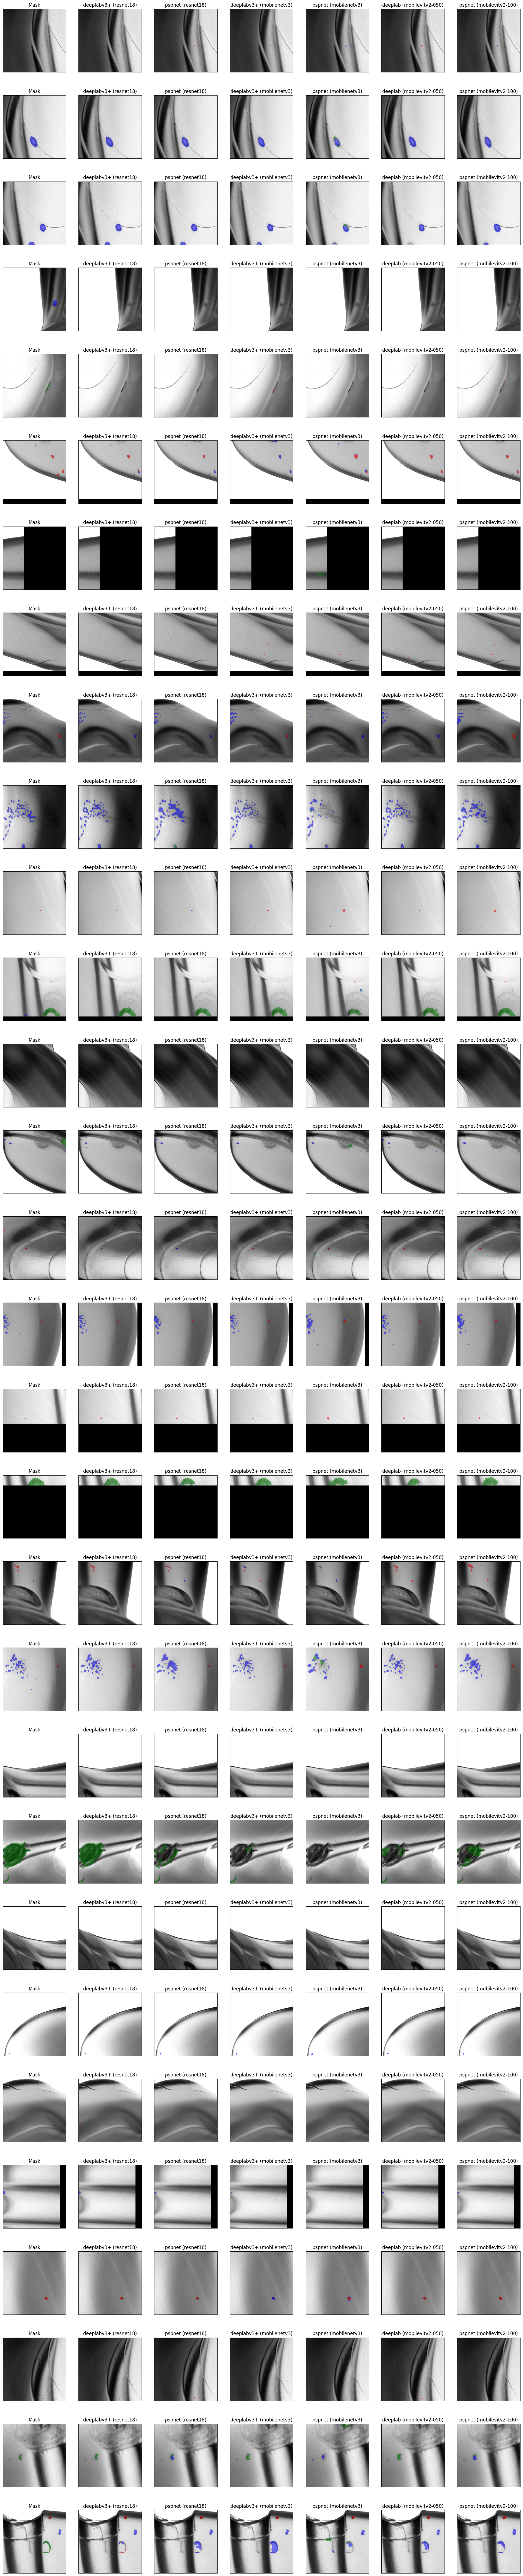

In [38]:
n = 300
indices = np.arange(0, n, 10)
fig, axis = plt.subplots(len(indices), 7, figsize=(24, len(indices)*4))
for row, i in zip(axis, indices):
    for ax in row:
        ax.imshow(images[i].squeeze(0).cpu().detach(), alpha=1, cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
    row[0].imshow(masks[i].squeeze(0).cpu().detach(), alpha=0.5, vmax=3, interpolation="nearest", cmap=ListedColormap(((0, 0, 0, 0), ("red"), ("green"), ("blue"))))  
    row[0].set_title("Mask")
    for j, title in zip(range(1, 7), titles):
        row[j].imshow(predictions[j-1][i].squeeze(0).cpu().detach(), alpha=0.5, vmax=3, interpolation="nearest", cmap=ListedColormap(((0, 0, 0, 0), ("red"), ("green"), ("blue"))))  
        row[j].set_title(title)

plt.show()

# Export models

In [6]:
import model_loader
import torch
import os
import numpy as np
from PIL import Image


def read_images(dir_path, normalization=255):
    images = []
    for image_name in os.listdir(dir_path):
        img_path = os.path.join(dir_path, image_name)
        image = torch.Tensor(np.array((Image.open(img_path).convert("L")))).to("cuda") / normalization
        image = image.unsqueeze(0)
        images.append(image)
    return images


images = read_images("cache_test/images/", 255)

models_names = ["deeplabv3plus_mobilevitv2_050_one_epoch_1.pth", "deeplabv3plus_mobilevitv2_100_one_epoch_1.pth", "deeplabv3plus_resnet18_one_epoch_1.pth", 
                "pspnet_mobilevitv2_100_one_epoch_1.pth", "pspnet_resnet18_one_epoch_1.pth"]
decoders = ["deeplabv3plus"] * 3 + ["pspnet"] * 2
encoders = ["tu-mobilevitv2_050", "tu-mobilevitv2_100", "resnet18", "tu-mobilevitv2_100", "resnet18"]
for model_name, decoder, encoder in zip(models_names, decoders, encoders):
    model = model_loader.SegmentationModel(decoder, encoder, 3, True)
    model.load_state_dict(torch.load(os.path.join("checkpoints", "one_epoch", model_name)))
    model.to("cuda")
    model.eval()
    traced = torch.jit.trace(model, images[0].unsqueeze(0))
    traced.save(os.path.join("exported\\one_epoch\\", f"{model_name}.torchscript"))

c:\Users\Opina\AppData\Local\Programs\Python\Python311\Lib\site-packages\segmentation_models_pytorch\base\model.py:17: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:
c:\Users\Opina\AppData\Local\Programs\Python\Python311\Lib\site-packages\timm\models\mobilevit.py:508: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  new_h, new_w = math.ceil(H / patch_h) * patch_h, math.ceil(W / patch_w) * patch_w
c:\Users\Opina\AppData\Local\Programs\Python\Python311\Lib\site-packages\timm\models\mobilevit.py:511: TracerWa

In [3]:
model = model_loader.SegmentationModel("deeplabv3plus", "resnet18", 3, True)
model.load_state_dict(torch.load("checkpoints\\full\\deeplab_resnet18_full_300.pth"))
model.to("cuda")
model.eval()

traced = torch.jit.trace(model, images[0].unsqueeze(0))
traced.save("deeplabv3plus_resnet18_300.torchscript")

In [4]:
model = model_loader.SegmentationModel("deeplabv3plus", "tu-mobilevitv2_050", 3, True)
model.load_state_dict(torch.load("checkpoints\\full\\deeplab_vit_full_300.pth"))
model.to("cuda")
model.eval()

traced = torch.jit.trace(model, images[0].unsqueeze(0))
traced.save("deeplabv3plus_mobilevitv2_050_300.torchscript")